# FISH - Pipeline - A Python notebook to visualize FISH data

```
Author: Luis U. Aguilera
Contact Info: luis.aguilera@colostate.edu

Copyright (c) 2021 Munsky Group 
Colorado State University 
Licensed under BSD 3-Clause License.
```

### Libraries

In [ ]:
# Importing libraries
import sys
import pathlib
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import glob
import numpy as np
import math
warnings.filterwarnings("ignore")

### Path to source directories

In [ ]:
# Defining directories
current_dir = pathlib.Path().absolute()
fa_dir = current_dir.parents[0].joinpath('src')

# Importing fish_analyses module
sys.path.append(str(fa_dir))
import fish_analyses as fa

# Path to credentials
desktop_path = pathlib.Path.home()/'Desktop'
path_to_config_file = desktop_path.joinpath('config.yml')


----

# Parameters defined by the user 

----

### Paths to images

In [ ]:
time_point = 'wo' # 'wo' '18min', '5h'
mandatory_substring='nuc_70__cyto_0__psfz_350__psfyx_160__ts_550_400'
connect_to_NAS = True

if time_point == 'wo':
    data_folder_path = pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220714/MS2-CY5_Cyto543_560_woStim')
    path_to_masks_dir = pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220714/MS2-CY5_Cyto543_560_woStim/masks_MS2-CY5_Cyto543_560_woStim___nuc_70__cyto_0.zip') 
    
if time_point == '18min':
    data_folder_path = pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220714/MS2-CY5_Cyto543_560_18minTPL_5uM')
    path_to_masks_dir = pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220714/MS2-CY5_Cyto543_560_18minTPL_5uM/masks_MS2-CY5_Cyto543_560_18minTPL_5uM___nuc_70__cyto_0.zip') 
    
if time_point == '5h':
    data_folder_path = pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220714/MS2-CY5_Cyto543_560_5hTPL_5uM')
    path_to_masks_dir = pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220714/MS2-CY5_Cyto543_560_5hTPL_5uM/masks_MS2-CY5_Cyto543_560_5hTPL_5uM___nuc_70__cyto_0.zip') 


In [ ]:
def extract_images_masks_dataframe( data_folder_path,path_to_masks_dir, mandatory_substring, path_to_config_file,connect_to_NAS, rescale=False,max_percentile=99.5):
    local_folder_path = pathlib.Path().absolute().joinpath('temp_local__'+data_folder_path.name)
    # This section downloads results including the dataframe
    if connect_to_NAS == True:
        list_local_files = fa.Utilities.read_zipfiles_from_NAS(list_dirs=data_folder_path,path_to_config_file=path_to_config_file,share_name='share', mandatory_substring=mandatory_substring, local_folder_path=local_folder_path)
        list_local_folders = fa.Utilities.unzip_local_folders(list_local_files,local_folder_path)
    else: 
        list_local_folders = data_folder_path # Use this line to process files from a local repository
    # Extracting the dataframe
    dataframe_file_path = glob.glob( str(list_local_folders[0].joinpath('dataframe_*')) )[0]
    dataframe = pd.read_csv(dataframe_file_path)
    # Extracting Original images
    local_data_dir, masks_dir, number_images, number_color_channels, list_files_names = fa.Utilities.read_images_from_folder( path_to_config_file, data_folder_path = data_folder_path, path_to_masks_dir = path_to_masks_dir,  download_data_from_NAS = connect_to_NAS, substring_to_detect_in_file_name = '.*_C0.tif')
    # Reading images from folders
    list_images, path_files, list_files_names, _ = fa.ReadImages(directory= local_data_dir).read()
    list_masks, path_files_masks, list_files_names_masks, _ = fa.ReadImages(directory= masks_dir).read()
    # Converting the images to int8
    #list_images_int8 = [fa.Utilities.convert_to_int8(img, rescale=rescale, min_percentile=0, max_percentile=max_percentile) for img in list_images  ]
    return list_images, list_masks, dataframe, number_images, number_color_channels


In [ ]:
%%capture
list_images, list_masks, dataframe, number_images, number_color_channels = extract_images_masks_dataframe( data_folder_path,path_to_masks_dir, mandatory_substring, path_to_config_file,connect_to_NAS)

In [ ]:
def image_cell_selection(cell_id, list_images, dataframe):
    # selecting only the dataframe containing the values for the selected field
    df_selected_cell = dataframe.loc[   (dataframe['cell_id']==cell_id)]
    selected_image_id = df_selected_cell.image_id.values[0]
    print('cell located in image_id: ', str(selected_image_id))
    # Cell location in image
    scaling_value_radius_cell = 1 # use this parameter to increase or decrease the number of radius to plot from the center of the cell.
    nuc_loc_x = df_selected_cell.nuc_loc_x.values[0]
    nuc_loc_y = df_selected_cell.nuc_loc_y.values[0]
    cyto_loc_x = df_selected_cell.cyto_loc_x.values[0]
    cyto_loc_y = df_selected_cell.cyto_loc_y.values[0]
    nuc_radius_px =  int(np.sqrt(df_selected_cell.nuc_area_px.values[0])*scaling_value_radius_cell)
    cyto_radius_px = int(np.sqrt(df_selected_cell.cyto_area_px.values[0])*scaling_value_radius_cell)
    # Detecting if a mask for the cytosol was used. If true, the code will plot the complete cell. Else, it will only plot the cell nucleus.
    if cyto_loc_x:
        plot_complete_cell = True
    else:
        plot_complete_cell = False
    if plot_complete_cell == True:
        x_min_value = cyto_loc_x - cyto_radius_px
        x_max_value = cyto_loc_x + cyto_radius_px
        y_min_value = cyto_loc_y - cyto_radius_px
        y_max_value = cyto_loc_y + cyto_radius_px
    else:
        x_min_value = nuc_loc_x - nuc_radius_px
        x_max_value = nuc_loc_x + nuc_radius_px
        y_min_value = nuc_loc_y - nuc_radius_px
        y_max_value = nuc_loc_y + nuc_radius_px
    # coordinates to select in the image 
    subsection_image_with_selected_cell = list_images[selected_image_id][:,y_min_value: y_max_value,x_min_value:x_max_value,:]
    # spots
    df_spots = df_selected_cell[['spot_id', 'z', 'y', 'x','is_nuc', 'is_cluster','cluster_size','spot_type']]
    df_spots = df_spots.reset_index(drop=True)
    # Removing columns with -1. 
    df_spots = df_spots[df_spots.spot_id >= 0]
    
    return subsection_image_with_selected_cell, df_spots


In [153]:
cell_id = 6
subsection_image_with_selected_cell, df_spots = image_cell_selection(cell_id=cell_id, list_images=list_images, dataframe=dataframe)

cell located in image_id:  0


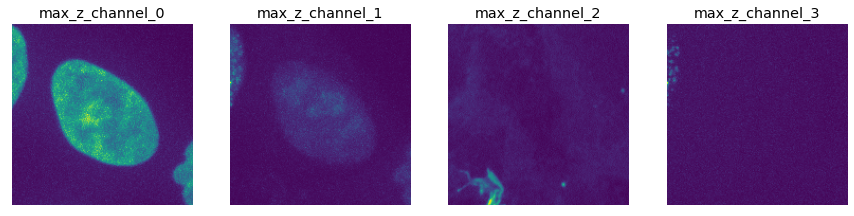

In [154]:
# print maximum projection
_, axes = plt.subplots(nrows = 1, ncols = number_color_channels, figsize = (15, 5))
for i in range(0, number_color_channels):
    axes[i].imshow( np.max(subsection_image_with_selected_cell[:,: ,:,i],axis=0))
    axes[i].grid(False)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title('max_z_channel_'+str(i) )

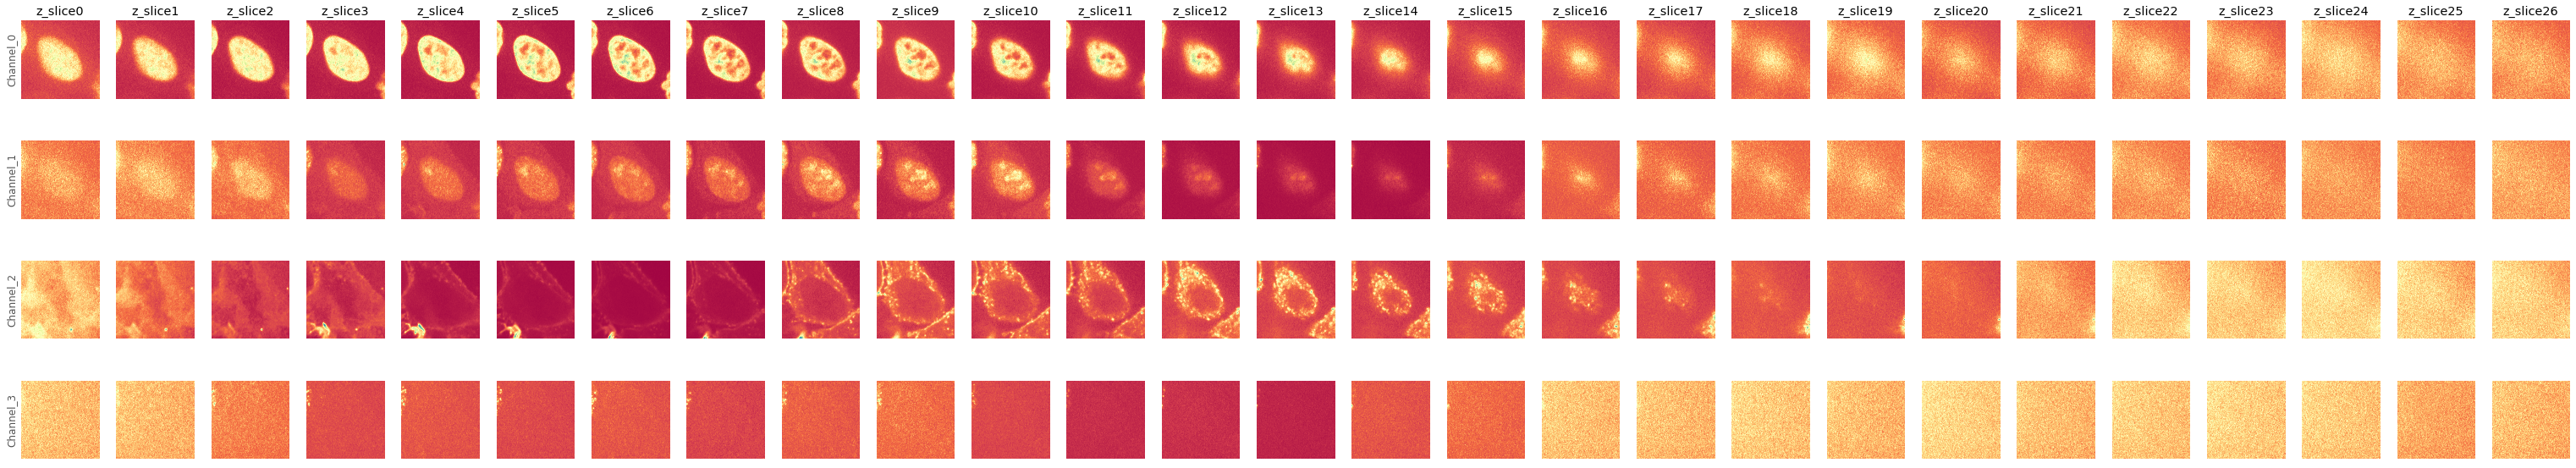

In [156]:
# print all z_slices
number_z_slices = subsection_image_with_selected_cell.shape[0]
_, axes = plt.subplots(nrows = number_color_channels , ncols = number_z_slices, figsize = ( number_z_slices*2, 10 ))
for i in range(0, number_z_slices):
    for j in range(0, number_color_channels):
        axes[j,i].imshow( subsection_image_with_selected_cell[i,: ,:,j],cmap='Spectral')
        axes[j,i].grid(False)
        axes[j,i].set_xticks([])
        axes[j,i].set_yticks([])
        if i ==0:
            axes[j,i].set_ylabel('Channel_'+str(j) )
            
        if j == 0:
            axes[j,i].set_title('z_slice'+str(i) )

In [157]:
df_spots

,spot_id,z,y,x,is_nuc,is_cluster,cluster_size,spot_type
0,0,3,471,393,1,0,0,0
1,1,4,478,398,1,0,0,0
2,2,5,484,397,1,0,0,0
3,3,6,476,387,1,0,0,0
4,4,6,482,399,1,0,0,0
5,5,7,473,387,1,0,0,0
6,6,7,476,417,1,0,0,0
7,7,7,477,424,1,0,0,0
8,8,8,474,424,1,0,0,0
9,9,8,489,435,1,0,0,0
